## COMPUTER VISION PROJECT V.1


In [1]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model


## Training Test Split


In [3]:
# # Set the paths to your folders
# fire_folder = '/content/drive/MyDrive/Fire-Detection/Fire'
# no_fire_folder = '/content/drive/MyDrive/Fire-Detection/No Fire'

# # Set the percentages for train, validation, and test sets
# train_percentage = 0.8
# validation_percentage = 0.1
# test_percentage = 0.1

# # Function to create train, validation, and test sets for a folder
# def create_splits(folder_path):
#     # Get the list of all image files in the folder
#     all_images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png','.JPG'))]

#     # Randomize the order of the files
#     random.shuffle(all_images)

#     # Calculate the number of images for each set
#     total_images = len(all_images)
#     train_size = int(total_images * train_percentage)
#     validation_size = int(total_images * validation_percentage)

#     # Split the images into train, validation, and test sets
#     train_images = all_images[:train_size]
#     validation_images = all_images[train_size:train_size + validation_size]
#     test_images = all_images[train_size + validation_size:]

#     # Create directories for train, validation, and test sets
#     train_folder = os.path.join(folder_path, 'Train')
#     validation_folder = os.path.join(folder_path, 'Validation')
#     test_folder = os.path.join(folder_path, 'Test')

#     os.makedirs(train_folder, exist_ok=True)
#     os.makedirs(validation_folder, exist_ok=True)
#     os.makedirs(test_folder, exist_ok=True)

#     # Move images to their respective folders
#     for image in train_images:
#         shutil.move(os.path.join(folder_path, image), os.path.join(train_folder, image))

#     for image in validation_images:
#         shutil.move(os.path.join(folder_path, image), os.path.join(validation_folder, image))

#     for image in test_images:
#         shutil.move(os.path.join(folder_path, image), os.path.join(test_folder, image))

# # Create splits for the "Fire" folder
# create_splits(fire_folder)

# # Create splits for the "No Fire" folder
# create_splits(no_fire_folder)


In [4]:
# Define the training and validation base directories
train_dir = '/content/drive/MyDrive/Fire-Detection/TRAIN'
validation_dir = '/content/drive/MyDrive/Fire-Detection/VAL'

# Directory with training horse pictures
train_fire_dir = os.path.join(train_dir, '1')
# Directory with training humans pictures
train_nofire_dir = os.path.join(train_dir, '0')
# Directory with validation horse pictures
validation_fire_dir = os.path.join(validation_dir, '1')
# Directory with validation human pictures
validation_nofire_dir = os.path.join(validation_dir, '0')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_fire_dir))} images of fire for training.\n")
print(f"There are {len(os.listdir(train_nofire_dir))} images of nofire for training.\n")
print(f"There are {len(os.listdir(validation_fire_dir))} images of fire for validation.\n")
print(f"There are {len(os.listdir(validation_nofire_dir))} images of nofire for validation.\n")

There are 691 images of fire for training.

There are 432 images of nofire for training.

There are 85 images of fire for validation.

There are 54 images of nofire for validation.



## Checking Sample Image in Each Classes

Sample fire image:


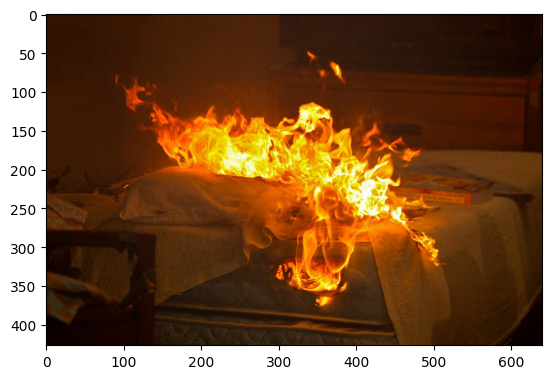


Sample nofire image:


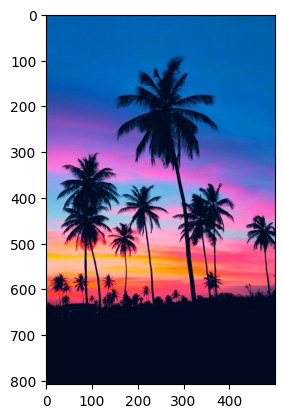

In [5]:
print("Sample fire image:")
plt.imshow(load_img(f"{os.path.join(train_fire_dir, os.listdir(train_fire_dir)[0])}"))
plt.show()

print("\nSample nofire image:")
plt.imshow(load_img(f"{os.path.join(train_nofire_dir, os.listdir(train_nofire_dir)[0])}"))
plt.show()

## Training and Validation Generators


In [26]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class
  # normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(224, 224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(224, 224))
  return train_generator, validation_generator


In [27]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1123 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


### 1 excess class is from .ipynb_checkpoint

## Transfer learning - Create the pre-trained model


In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-03-09 13:57:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   240MB/s    in 0.3s    

2024-03-09 13:57:40 (240 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                  include_top = False,
                                  weights = 'imagenet')

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False


  return pre_trained_model


In [11]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

### Checking trainable parameters

In [12]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


## Creating callbacks

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [29]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)

  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

Check that everything works as expected:

In [30]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [31]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [32]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024 ,activation='relu')(x) # ,input_shape=(110592,),
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model


In [33]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 122,223,521 total parameters in this model.
There are 113,248,257 trainable parameters in this model.


In [34]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
36/36 - 25s - loss: 0.4235 - accuracy: 0.8967 - val_loss: 0.0987 - val_accuracy: 0.9493 - 25s/epoch - 703ms/step
Epoch 2/100
36/36 - 19s - loss: 0.0516 - accuracy: 0.9822 - val_loss: 0.1142 - val_accuracy: 0.9493 - 19s/epoch - 530ms/step
Epoch 3/100
36/36 - 23s - loss: 0.0079 - accuracy: 0.9982 - val_loss: 0.0688 - val_accuracy: 0.9855 - 23s/epoch - 641ms/step
Epoch 4/100

Reached 99.9% accuracy so cancelling training!
36/36 - 21s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9710 - 21s/epoch - 582ms/step


## Checking Accuracy

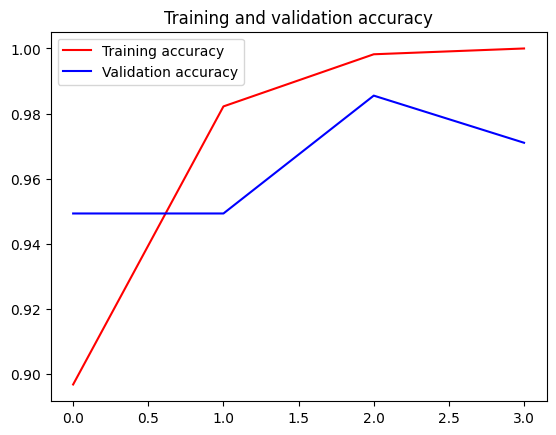

<Figure size 640x480 with 0 Axes>

In [35]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### It seems like the Training Accuracy and Validation Accuracy graph is converging to a close value.. therefore its not overtrained or undertrained...

## Trying the trained model for real life pic

In [38]:
from google.colab import files

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a Fire ")
  else:
    print(fn + " is no Fire")


Saving IMG_1371.jpeg to IMG_1371 (1).jpeg
1/1 [==============================] - 0s 24ms/step
[0.99473864]
IMG_1371 (1).jpeg is a Fire 


In [39]:
from tensorflow.keras.models import load_model, save_model

# Save the entire model to a HDF5 file
save_model(model, 'CV_Proj_V1.h5')

# To load the model back
loaded_model = load_model('CV_Proj_V1.h5')

<ipython-input-39-00e2da159021>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'CV_Proj_V1.h5')


In [22]:
# import cv2
# import numpy as np
# from PIL import Image
# import tensorflow as tf
# from keras.preprocessing import image

# #LOAD SAVEDMODEL
# loaded_model = load_model("CV_Proj_V1.h5")
# video = cv2.VideoCapture(0)

# while True:
#     _, frame = video.read()

#     # Convert the captured frame into RGB
#     # im = Image.fromarray(frame)

#     # Resizing into 224x224 because we trained the model with this image size
#     im = im.resize((224, 224))
#     img_array = image.img_to_array(im)
#     img_array = np.expand_dims(img_array, axis=0) / 255

#     probabilities = model.predict(img_array)[0]

#     # Calling the predict method on the model to predict 'fire' on the image
#     prediction = np.argmax(probabilities)

#     # If prediction is 0, which means there is fire in the frame
#     if prediction == 0:
#         frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
#         print(probabilities[prediction])

#     # Display the frame
#     cv2.imshow("Capturing", frame)

#     key = cv2.waitKey(1)
#     if key == ord('q'):
#         break

# video.release()
# cv2.destroyAllWindows()